In [1]:
import glob
import os
import copy

import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl
import matplotlib as mpl

In [2]:
import importlib
%matplotlib notebook

In [3]:
import analyze2p.utils as hutils
import analyze2p.plotting as pplot
#import analyze2p.receptive_fields.utils as rfutils
import analyze2p.aggregate_datasets as aggr
#import analyze2p.extraction.rois as roiutils
#import analyze2p.retinotopy.utils as retutils
import analyze2p.retinotopy.segment as seg
import analyze2p.scatter as sct

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [4]:
# Meta data
visual_areas=['V1', 'Lm', 'Li']
pplot.set_plot_params()
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


In [5]:
regr_list=[]
for (va, dk), g in meta.groupby(['visual_area', 'datakey']):
    retinorun, AZMAP_NP, ELMAP_NP, GVECTORS = sct.load_vectors_and_maps(dk, va, 
                                                                create_new=False)
    aligned_np, REGR_NP, regr_np_meas = sct.transform_and_fit_neuropil(dk, va, retinorun,
                                                        GVECTORS)
    regr_np_meas['aligned'] = False
    REGR_NP['aligned'] = True
    df_ = pd.concat([regr_np_meas, REGR_NP], axis=0, ignore_index=True)
    df_['visual_area'] = va
    df_['datakey'] = dk
    regr_list.append(df_)
all_regr = pd.concat(regr_list, axis=0, ignore_index=True)
print(all_regr.shape)

    found: 20191105_JC117_fov1, Li dict_keys(['Li', 'Lm'])
    found: 20191111_JC120_fov1, Li dict_keys(['Li', 'Lm'])
    found: 20190504_JC078_fov1, Lm dict_keys(['Lm', 'V1'])
    found: 20190508_JC083_fov1, Lm dict_keys(['Lm', 'V1'])
    found: 20190509_JC078_fov1, Lm dict_keys(['Lm', 'V1'])
    found: 20190512_JC083_fov1, Lm dict_keys(['Lm', 'V1'])
    found: 20190517_JC083_fov1, Lm dict_keys(['Lm', 'V1'])
    found: 20191105_JC117_fov1, Lm dict_keys(['Li', 'Lm'])
    found: 20191111_JC117_fov1, Lm dict_keys(['Lm', 'V1'])
    found: 20191111_JC120_fov1, Lm dict_keys(['Li', 'Lm'])
    found: 20190504_JC078_fov1, V1 dict_keys(['Lm', 'V1'])
    found: 20190508_JC083_fov1, V1 dict_keys(['Lm', 'V1'])
    found: 20190509_JC078_fov1, V1 dict_keys(['Lm', 'V1'])
    found: 20190512_JC083_fov1, V1 dict_keys(['Lm', 'V1'])
    found: 20190517_JC083_fov1, V1 dict_keys(['Lm', 'V1'])
    found: 20191111_JC117_fov1, V1 dict_keys(['Lm', 'V1'])
(216, 10)


In [6]:
# Which sites have >1 visual area?
multiple_areas=[]
for dk, g in all_regr.groupby('datakey'):
    n_vas = len(g['visual_area'].unique())
    if n_vas>1:
        multiple_areas.append(dk)
print("%i sites have >1 visual area" % len(multiple_areas))

8 sites have >1 visual area


In [7]:
# Which sites have a worse relationship between retino & ctx due to transformation?
pre_ = all_regr[~all_regr['aligned']].copy().reset_index(drop=True)
post_ = all_regr[all_regr['aligned']].copy().reset_index(drop=True)

worse_on_one = np.where(pre_['R2'].round(2)>post_['R2'].round(2))[0]
worse_on_one_datakeys = pre_.iloc[worse_on_one][['visual_area', 'datakey']].drop_duplicates()
all_datakeys = pre_[['visual_area', 'datakey']].drop_duplicates()
print("%s of %i datasets are WORSE :( ..." \
      % (len(worse_on_one_datakeys), len(all_datakeys)))

22 of 54 datasets are WORSE :( ...


In [8]:
mean_of_conds = all_regr.groupby(['visual_area', 'datakey', 'aligned'])['R2']\
                        .mean().reset_index()
# Which sites have a worse relationship between retino & ctx due to transformation?
pre_ = mean_of_conds[~mean_of_conds['aligned']].copy().reset_index(drop=True)
post_ = mean_of_conds[mean_of_conds['aligned']].copy().reset_index(drop=True)

worse_on_avg = np.where(pre_['R2'].round(2)>post_['R2'].round(2))[0]
worse_on_avg_datakeys = pre_.iloc[worse_on_avg][['visual_area', 'datakey']].drop_duplicates()
print("%s of %i datasets are WORSE :( ..." \
      % (len(worse_on_avg_datakeys), len(all_datakeys)))

11 of 54 datasets are WORSE :( ...


In [12]:
worse_dkeys = pd.merge(worse_on_one_datakeys, worse_on_avg_datakeys, how='outer')
worse_dkeys.shape

(22, 2)

In [13]:
worse_on_avg_datakeys

,visual_area,datakey
0,Li,20190522_JC089_fov1
18,Lm,20190430_JC078_fov1
20,Lm,20190506_JC080_fov1
24,Lm,20190513_JC078_fov1
29,Lm,20190618_JC097_fov1
35,V1,20190420_JC076_fov1
39,V1,20190508_JC083_fov1
43,V1,20190512_JC083_fov1
44,V1,20190517_JC083_fov1
47,V1,20190615_JC097_fov2


In [14]:
worse_on_one_datakeys

,visual_area,datakey
0,Li,20190522_JC089_fov1
4,Li,20190528_JC092_fov1
7,Li,20190602_JC091_fov1
19,Li,20190617_JC099_fov1
20,Li,20191012_JC113_fov1
34,Lm,20190423_JC076_fov1
37,Lm,20190430_JC078_fov1
38,Lm,20190504_JC078_fov1
41,Lm,20190506_JC080_fov1
44,Lm,20190509_JC078_fov1


In [23]:
all_worse = pd.merge(all_regr, worse_on_avg_datakeys, on=['visual_area', 'datakey'], 
                     how='inner').drop_duplicates()
# add datakey num for plotting
dkey_lut={}
for va, g in all_worse.groupby(['visual_area']):
    curr_dkeys = g['datakey'].unique()
    d_lut = dict((v, k) for k, v in enumerate(curr_dkeys))
    dkey_num = [d_lut[v] for v in g['datakey'].values]
    all_worse.loc[g.index, 'datakey_num'] = dkey_num
    dkey_lut[va] = d_lut.copy()
all_worse.head()

,R2,RMSE,pearson_p,pearson_r,coefficient,intercept,cond,aligned,visual_area,datakey,datakey_num
0,0.634436,5.242758,1.904217e-06,0.796515,0.100070,-18.517567,az,False,Li,20190522_JC089_fov1,0.0
1,0.912649,1.122466,1.145849e-13,0.955327,0.023639,-0.743580,el,False,Li,20190522_JC089_fov1,0.0
2,0.613574,5.390277,3.658591e-06,0.783310,0.064341,-27.290887,az,True,Li,20190522_JC089_fov1,0.0
3,0.766843,1.833850,9.926899e-09,0.875696,0.034690,4.810463,el,True,Li,20190522_JC089_fov1,0.0
4,0.909046,5.075299,1.664188e-116,-0.953439,-0.069682,40.166469,az,False,Lm,20190430_JC078_fov1,0.0


<IPython.core.display.Javascript object>


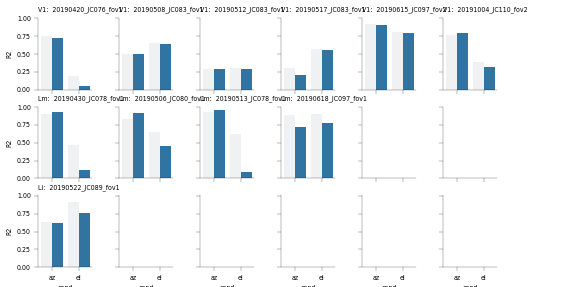

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:648: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


In [29]:
%matplotlib notebook
fg = sns.FacetGrid(data=all_worse, row='visual_area', row_order=visual_areas, 
                   height=1.7, col='datakey_num', aspect=1)
fg.map(sns.barplot, 'cond', 'R2', 'aligned')

for ax in fg.axes.flat:
    ax.set_title('')
    #pl.setp(ax.texts, text="")
    # remove the original texts
fg.set_titles(row_template='{row_name}', col_template='{col_name}')
axes = fg.axes.flatten()
for ax in axes:
    currt = ax.get_title()
    ax.set_title('') # remove old
    va = currt.split(' ')[0]
    snum = float(currt.split(' ')[2])
    #print(va, snum)
    d_lut = dkey_lut[va].copy()
    if snum <= max(d_lut.values()):
        dk = [k for k, v in d_lut.items() if v==snum][0]
        new_t = '%s:  %s' % (va, dk)
        ax.set_title(new_t, fontsize=6, loc='left')
pl.subplots_adjust(left=0.05, right=0.65, bottom=0.3, wspace=0.5)

In [26]:
dkey_lut

{'Li': {'20190522_JC089_fov1': 0},
 'Lm': {'20190430_JC078_fov1': 0,
  '20190506_JC080_fov1': 1,
  '20190513_JC078_fov1': 2,
  '20190618_JC097_fov1': 3},
 'V1': {'20190420_JC076_fov1': 0,
  '20190508_JC083_fov1': 1,
  '20190512_JC083_fov1': 2,
  '20190517_JC083_fov1': 3,
  '20190615_JC097_fov2': 4,
  '20191004_JC110_fov2': 5}}

In [51]:
pd.merge(worse_on_one_datakeys, worse_on_avg_datakeys, 
         on=['visual_area', 'datakey'], how='inner')


,visual_area,datakey
0,Li,20190522_JC089_fov1
1,Li,20190609_JC099_fov1
2,Lm,20190430_JC078_fov1
3,Lm,20190506_JC080_fov1
4,Lm,20190513_JC078_fov1
5,Lm,20190618_JC097_fov1
6,Lm,20191111_JC117_fov1
7,V1,20190420_JC076_fov1
8,V1,20190508_JC083_fov1
9,V1,20190509_JC078_fov1


In [50]:
worse_on_one

array([  1,   4,   7,  13,  19,  20,  34,  37,  38,  41,  44,  49,  58,
        59,  64,  65,  70,  71,  76,  78,  81,  87,  88,  89,  94,  95,
       100, 103, 106])

In [33]:
va='V1'
curr_ds = all_worse[all_worse.visual_area==va]

In [34]:
for (dk, cnd), g in curr_ds.groupby(['datakey', 'cond']):
    post = float(g[g.aligned]['R2'].round(2).values)
    pre = float(g[~g.aligned]['R2'].round(2).values)
    diff = post-pre
    if diff<0:
        print('%s, %s: pre, %.2f | post, %.2f' % (dk, cnd, pre, post)) #diff)

20190420_JC076_fov1, az: pre, 0.75 | post, 0.72
20190420_JC076_fov1, el: pre, 0.19 | post, 0.05
20190508_JC083_fov1, az: pre, 0.33 | post, 0.23
20190509_JC078_fov1, el: pre, 0.48 | post, 0.41
20190512_JC083_fov1, el: pre, 0.30 | post, 0.25
20190517_JC083_fov1, az: pre, 0.30 | post, 0.21
20190517_JC083_fov1, el: pre, 0.57 | post, 0.56
20190615_JC097_fov2, az: pre, 0.92 | post, 0.91
20190615_JC097_fov2, el: pre, 0.81 | post, 0.79
20191004_JC110_fov2, el: pre, 0.40 | post, 0.33
20191111_JC117_fov1, az: pre, 0.92 | post, 0.82


In [91]:
g

,R2,RMSE,pearson_p,pearson_r,coefficient,intercept,cond,aligned,visual_area,datakey
68,0.751544,4.012495,8.022210e-27,0.866916,0.031379,16.805055,az,False,V1,20190420_JC076_fov1
69,0.751544,4.012495,8.022210e-27,0.866916,0.031379,16.805055,az,False,V1,20190420_JC076_fov1
72,0.718691,4.269544,1.418926e-24,0.847756,0.031492,19.271050,az,True,V1,20190420_JC076_fov1
73,0.718691,4.269544,1.418926e-24,0.847756,0.031492,19.271050,az,True,V1,20190420_JC076_fov1


In [35]:
dk='20190615_JC097_fov2'
va='V1'
retinorun, AZMAP_NP, ELMAP_NP, GVECTORS = sct.load_vectors_and_maps(dk, va, 
                                                            create_new=True)

... calculating global gradients (20190615_JC097_fov2, V1)


<IPython.core.display.Javascript object>


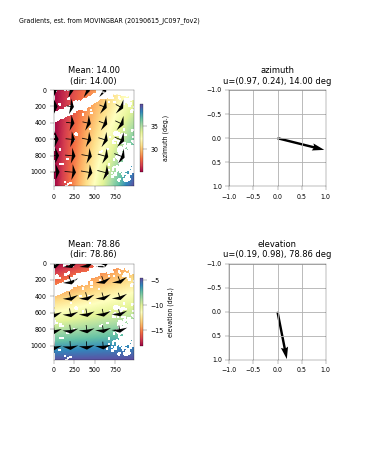

Text(0.05, 0.95, 'Gradients, est. from MOVINGBAR (20190615_JC097_fov2)')

In [36]:
%matplotlib notebook
fig = sct.plot_gradients(dk, va, retinorun, cmap='Spectral')
fig.text(0.05, 0.95, 'Gradients, est. from MOVINGBAR (%s)' % dk)

In [37]:
aligned_np, REGR_NP, regr_np_meas = sct.transform_and_fit_neuropil(dk, va, retinorun,
                                                    GVECTORS)
# Save
sct.update_models(dk, va, REGR_NP)

# Q:  why is reversal (LM) wonky
# Q:  fit SOMA to eitehr BAR or TILE gradient
print("MEASURED:")
print(regr_np_meas.to_markdown())
print("ALIGNED:")
print(REGR_NP.to_markdown())

MEASURED:
|    |       R2 |    RMSE |    pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|-------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.915619 | 1.03722 | 1.79628e-175 |    0.95688  |     0.0130241 |     24.9659 | az     |
|  1 | 0.811831 | 1.33502 | 3.40108e-119 |    0.901016 |     0.0100562 |    -16.4017 | el     |
ALIGNED:
|    |       R2 |    RMSE |    pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|-------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.911007 | 1.06519 | 9.73394e-172 |    0.954467 |    0.0128125  |     23.0187 | az     |
|  1 | 0.79245  | 1.40209 | 2.58462e-112 |    0.890197 |    0.00987387 |    -17.0998 | el     |


<IPython.core.display.Javascript object>


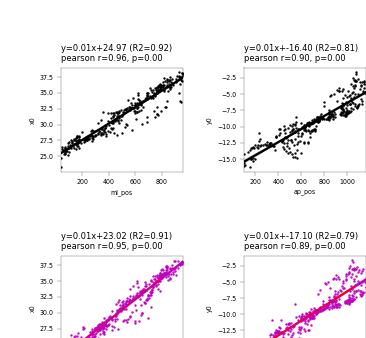

In [38]:
fig = sct.plot_measured_and_aligned(aligned_np, REGR_NP, regr_np_meas)


In [39]:
importlib.reload(sct)

<module 'analyze2p.scatter' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py'>

Do model? True
... loading gradient vectors (20190615_JC097_fov2, V1)


<IPython.core.display.Javascript object>


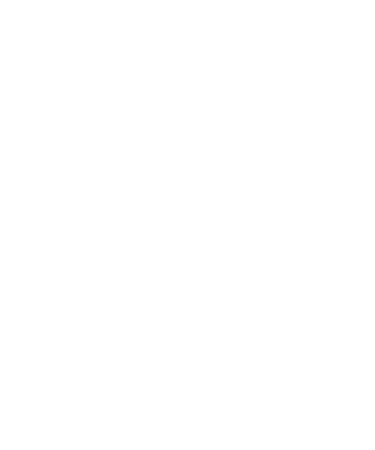

... estimating linear fit (20190615_JC097_fov2, V1)


<IPython.core.display.Javascript object>


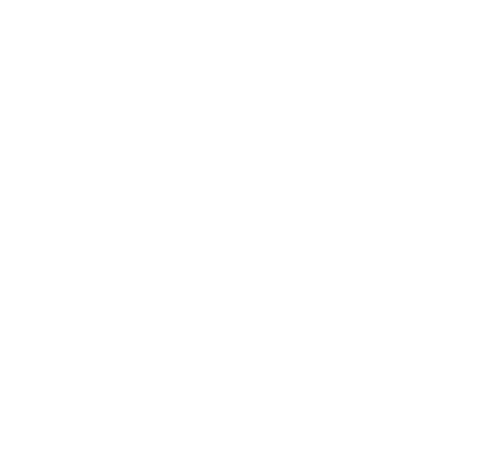

<IPython.core.display.Javascript object>


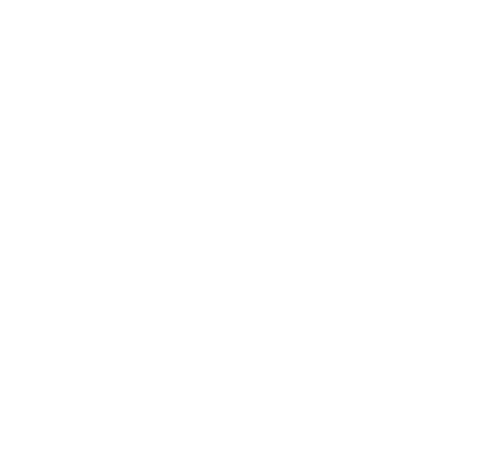

<IPython.core.display.Javascript object>


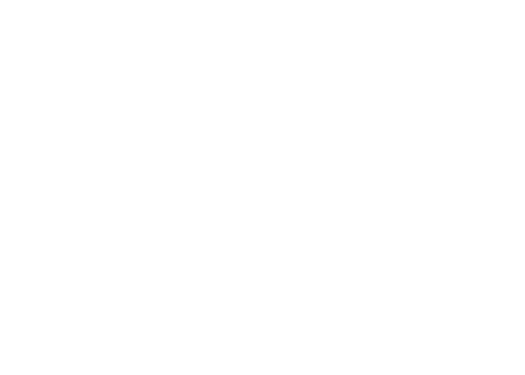

... calculating deviations


<IPython.core.display.Javascript object>


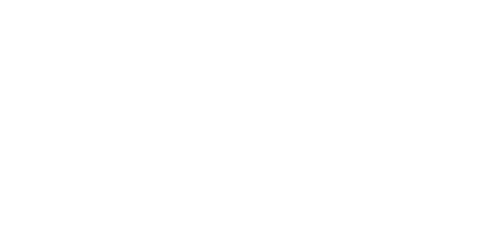

In [40]:
devs = sct.do_scatter_analysis(dk, va, experiment='rfs10', 
                               return_best_model=True,
                                do_gradients=False, do_model=True)

Do model? True
... loading gradient vectors (20190615_JC097_fov2, V1)


<IPython.core.display.Javascript object>


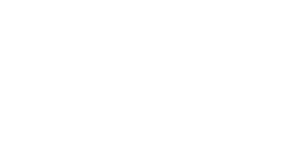

... estimating linear fit (20190615_JC097_fov2, V1)


<IPython.core.display.Javascript object>


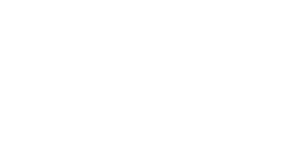

<IPython.core.display.Javascript object>


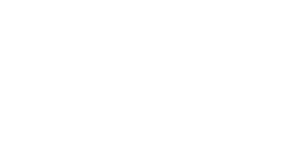

<IPython.core.display.Javascript object>


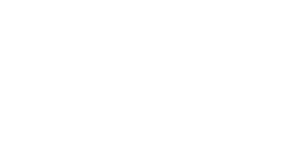

... calculating deviations


<IPython.core.display.Javascript object>


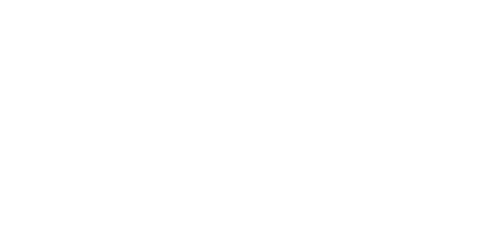

In [43]:
devs_aligned = sct.do_scatter_analysis(dk, va, experiment='rfs10', 
                               return_best_model=False,
                                do_gradients=False, do_model=True)

In [44]:
devs

,cell,deg_scatter,dist_scatter,inbounds,axis
0,4,2.735750,210.052458,False,az
1,7,26.442895,2030.300547,False,az
2,8,4.302492,330.347784,False,az
3,10,2.089309,160.418326,False,az
4,11,1.288590,98.938652,False,az
...,...,...,...,...,...
251,326,2.200826,218.853115,True,el
252,328,0.276903,27.535603,False,el
253,330,1.924810,191.405721,False,el
254,336,0.954041,94.871094,True,el


<IPython.core.display.Javascript object>


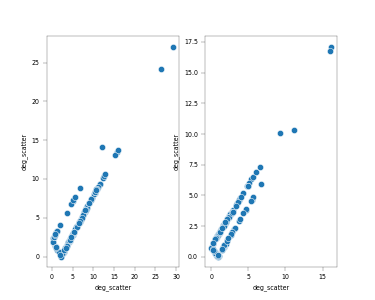

In [45]:
fig, axn  = pl.subplots(1,2)
for ax, (cnd, cnd_df) in zip(axn.flat, devs.groupby(['axis'])):
    cnd_df_aligned = devs_aligned[devs_aligned.axis==cnd]
    sns.scatterplot(cnd_df['deg_scatter'], cnd_df_aligned['deg_scatter'], ax=ax)